In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import math

pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from preprocess.functions.date_inspector import load_files
from eda.functions.eda import show_correlation, show_normalized_mutual_information, show_relative_density_plot
from dataset_manager import DatasetManager

In [3]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), 'data', 'raw', 'kma'))
print(data_dir)

/home/jeon/Desktop/kpx/models/data/raw/kma


In [5]:
observation_list = ['df_kma_obs_Jeju-do_Seogwipo-si_Pyoseon-myeon_2017.pkl',
                   'df_kma_obs_Jeju-do_Seogwipo-si_Pyoseon-myeon_2018.pkl',
                   'df_kma_obs_Jeju-do_Seogwipo-si_Pyoseon-myeon_2019.pkl']

forecast_list = ['df_kma_forecast_Jeju-do_Seogwipo-si_Pyoseon-myeon_2017.pkl',
                'df_kma_forecast_Jeju-do_Seogwipo-si_Pyoseon-myeon_2018.pkl',
                'df_kma_forecast_Jeju-do_Seogwipo-si_Pyoseon-myeon_2019.pkl']

filename_power = 'df_kpx_wind_2.pkl'

df_observation, df_forecast, df_power = load_files(observation_list, forecast_list, filename_power)

### preprocess

In [6]:
df_observation['datetime'] = pd.to_datetime(df_observation['datetime'])
df_observation['date'] = pd.to_datetime(df_observation['date'])
df_merged = pd.merge(df_observation.drop(['location'], axis=1), 
                     df_power.drop(['location', '풍향(16방위)', '풍속(m/s)'], axis=1), 
                     how='inner', 
                     on=['datetime', 'date'])

df_merged_new = df_merged.drop(['datetime','date'],axis=1)
df_merged_date = df_merged[['datetime','date']]

In [7]:
#### Scaling
scaler = MinMaxScaler()
scaler.fit(df_merged_new)
df=scaler.transform(df_merged_new)

### Data Load

In [10]:
df_ewp_a = pd.read_pickle(os.path.join(os.getcwd(), '..', 'data','df_ewp_a.pkl'))
df_ewp_b = pd.read_pickle(os.path.join(os.getcwd(),'..', 'data','df_ewp_b.pkl'))
df_ewp_c = pd.read_pickle(os.path.join(os.getcwd(),'..', 'data','df_ewp_c.pkl'))

In [18]:
df_kma_obs_2017 = pd.read_pickle(os.path.join(os.getcwd(), '..', 'data','df_kma_obs_Chungcheongnam-do_Seosan-si_Suseok-dong_2017.pkl'))
df_kma_obs_2018 = pd.read_pickle(os.path.join(os.getcwd(),'..', 'data','df_kma_obs_Chungcheongnam-do_Seosan-si_Suseok-dong_2018.pkl'))
df_kma_forecast_2017 = pd.read_pickle(os.path.join(os.getcwd(),'..', 'data','df_kma_forecast_Chungcheongnam-do_Dangjin-si_Seongmun-myeon_2017.pkl'))
df_kma_forecast_2018 = pd.read_pickle(os.path.join(os.getcwd(),'..', 'data','df_kma_forecast_Chungcheongnam-do_Dangjin-si_Seongmun-myeon_2018.pkl'))

## kma 관측치로 test

In [19]:
# 우선 nan 처리
df_kma_obs_2017 = df_kma_obs_2017.fillna(method='ffill')

In [20]:
df_kma_obs_2017_matrix = df_kma_obs_2017.loc[:,"기온(°C)":"전운량(10분위)"].values
X = df_kma_obs_2017_matrix

#### minmax scaler

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

### PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed=pca.fit_transform(X_scaled)

In [22]:
transformed.shape

(8723, 2)

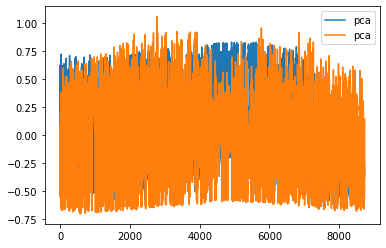

In [23]:
plt.plot(transformed, label='pca')
plt.legend()
plt.show()

# K-MEANS

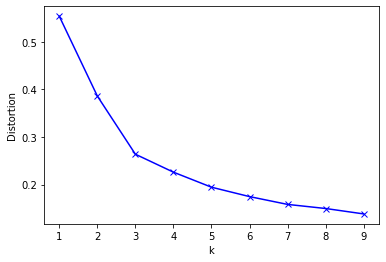

In [24]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
#그림을 보면 k는 2~3정도가 적절(3해보자)
distortions = []
K =range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformed)
    kmeanModel.fit(transformed)
    distortions.append(sum(np.min(cdist(transformed, kmeanModel.cluster_centers_, 'euclidean'),axis=1))/transformed.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(transformed)
y_kmeans = kmeans.predict(transformed)

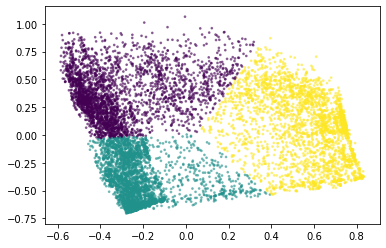

In [26]:
plt.scatter(transformed[:,0],transformed[:,1], c=y_kmeans, s=3, alpha=0.5, cmap='viridis')

### Not dimensionality reduction

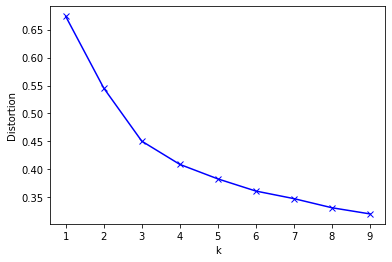

In [27]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
#그림을 보면 k는 2~3정도가 적절(3해보자)
distortions = []
K =range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled)
    kmeanModel.fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'),axis=1))/X_scaled.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [28]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

#### kmeans후에 pca

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed=pca.fit_transform(X_scaled)

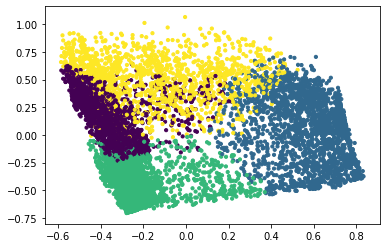

In [30]:
plt.scatter(transformed[:,0],transformed[:,1], c=y_kmeans, s=10, cmap='viridis')

#### T-sne 후에 kmeans

In [31]:
from sklearn.manifold import TSNE

In [32]:
model = TSNE(random_state=0)
transformed = model.fit_transform(X_scaled)

xs = transformed[:,0]
ys = transformed[:,1]

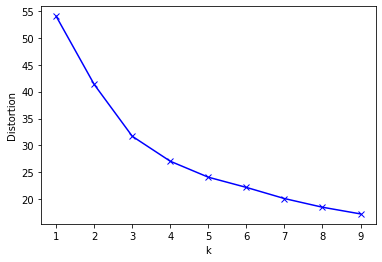

In [33]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
distortions = []
K =range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformed)
    kmeanModel.fit(transformed)
    distortions.append(sum(np.min(cdist(transformed, kmeanModel.cluster_centers_, 'euclidean'),axis=1))/transformed.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(transformed)
y_kmeans = kmeans.predict(transformed)

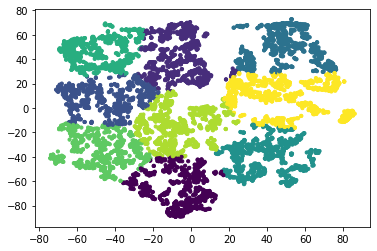

In [35]:
plt.scatter(transformed[:,0],transformed[:,1], c=y_kmeans, s=10, cmap='viridis')